In [1]:
def get_hist_variable_by_hours(input_df,input_primary_field):
    input_constraint_field = 'hours'
    
    #//*** Get a value distribution of the primary field
    primary_value_count = input_df[input_primary_field].value_counts().sort_values(ascending=False)

    # //*** Build a list of summed constraint field(hours) for each primary_field (jobcode) category
    # //*** Loop through each primary field value (billable jobcode ) to get the total hours for that constraint (job)
    primary_value_distribution = {}
    
    for x in range(0,len(primary_value_count.index)):
        loop_key = primary_value_count.index[x]
    
        # //*** get total hours for each job
        primary_value_distribution[loop_key] = input_df[input_df[input_primary_field] == loop_key ][input_constraint_field].sum()
    
    # //*****************************
    # //*** Sort by Constrained Sums
    # //*****************************
    # //*** https://www.geeksforgeeks.org/python-sort-python-dictionaries-by-key-or-value/
    # //*** Builds a sorted dictionary
    primary_value_distribution = sorted(primary_value_distribution.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
    primary_keys = []
    #//*** Round the hours to get a slightly better picture of the distribution
    primary_values_munge = []
    # //*** Pull the sorted dictionary apart
    for x in primary_value_distribution:
        primary_keys.append(x[0])
        
        #//*** Values less than 1 become 1 hour.
        if int(x[1]) < 1:
            primary_values_munge.append(1)
        else:
            primary_values_munge.append(round(x[1],0))

    #//*** Return primary_field distribution as a histogram 
    return pd.Series(primary_values_munge).value_counts().sort_index()
#//**************************************
#//*** END get_hist_variable_by_hours
#//**************************************


Forthis project, conduct a regression analysis on either one dependent and one explanatory variable, or multiple explanatory variables(Chapter 10 & 11)

In [2]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

In [3]:
# //*** Define Global Values
g = {
    'obfuscate': {},
    'combined_df_filename' : 'combined.dat',
    'days_of_week' : ["Monday","Tuesday","Wednesday","Thursday","Friday"],
    'person' : {}
}
#"Saturday","Sunday"

# //*** Load keys.json
rawInput = ""
with open('keys.json', 'r') as readfile:
    for f in readfile.readlines():
        rawInput = rawInput + f + "\n"
readfile.close()

g['obfuscate'] = json.loads(rawInput)



# //*******************************************
# //*** Load Combined df - Master Data Frame
# //*******************************************
combined_df = pd.read_csv(g['combined_df_filename'])

# //*** Delete First Column, I believe is a CSV artifact
del combined_df[ combined_df.columns[0] ]

# //**** Convert Local Date to Date Time Format
# //**** Strip out exact time and keep date
combined_df['local_date'] = combined_df['local_date'].str.replace(" 00:00:00","")

# //*** Run conversion once, ie check for timestamp property in first value
# //*** Just a wee bit of fail safely
if "Timestamp" not in str(type(combined_df['local_date'][0])):
    # //**** Convert String to date
    dateCol = pd.to_datetime(combined_df['local_date'], format='%Y-%m-%d')
    
    combined_df['local_date'] = dateCol
    
    
    
    # //*** Build Days of the Week Column as an Integer
    combined_df['day_int'] = combined_df['local_date'].dt.dayofweek

    # //*** Build Day Column as a String [ Monday ~ Sunday ]
    # //*** Start With am empty list and convert 'day_int' column into a list of strings

    day_list = []

    date_dict = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}

    for x in range(0,len(combined_df['day_int'])):
        day_list.append(date_dict[combined_df['day_int'][x]])

    # //*** Convert day_list to Series and add as 'day column'
    combined_df['day'] = pd.Series(day_list)

# //*** Remove listings where hours == 0
combined_df =  combined_df[combined_df['hours'] > 0]

In [4]:
print(combined_df.head())

  local_date  hours                    jobcode_1  \
0 2019-01-01   8.00                      Holiday   
1 2019-01-02   1.75                 Gabel Energy   
2 2019-01-02   1.08  ALTUS Architecture + Design   
3 2019-01-02   1.58                 Gabel Energy   
4 2019-01-02   1.25        BDE Architecture Inc.   

                                  jobcode_2  \
0                                       NaN   
1                                       NaN   
2  19009 - Munson Residence and Guest House   
3                                       NaN   
4  17214 Walnut Creek Transit Village Phase   

                                     activity billable           class  \
0                                         NaN      NaN             NaN   
1  Gabel: Project Coordination (non-billable)       No        Overhead   
2                       Energy Model/Takeoffs       No     Residential   
3                                 Gabel: Misc       No        Overhead   
4                       Energy Mod

### A minimum of 5 variables in your dataset used during your analysis (for help with selecting, the author made his selection on page 6 of your book).  Consider what you think could have an impact on your question –remember this is never perfect, so don’t be worried if you miss one(Chapter 1) ###

**5 Variables**

Hours - Primary Variable: 272 0 hour entries. These were removed from the data set. These are likely incorrect employee entries, likely inputting the wrong job code clocking out and failing to remove the zero length job from the time tracking software.

Hours / Billable

Hours / Overhead

Hours / Salary

Hours / Hourly

Hours / Jobcode 2

Hours / Jobcode 1

### Describe what the 5 variables mean in the dataset(Chapter 1) ###

### Include a histogram of each of the 5variables –in your summary and analysis, identify any outliers and explain the reasoning for them being outliers and how you believe they should be handled(Chapter 2). ###


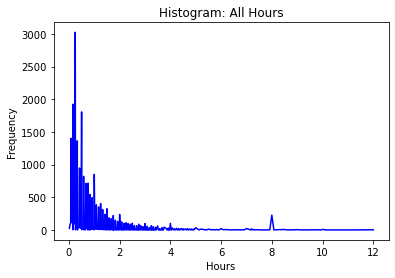

In [5]:
#//*** Get Histogram of total Hours 
total_hours_hist = combined_df['hours'].value_counts().sort_index()

plt.plot(total_hours_hist.index, total_hours_hist,1,color="b")
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title("Histogram: All Hours")
plt.show()


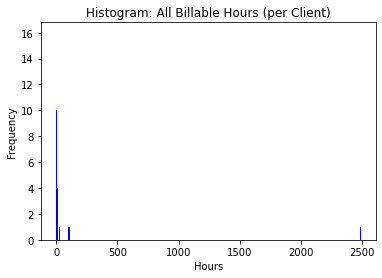

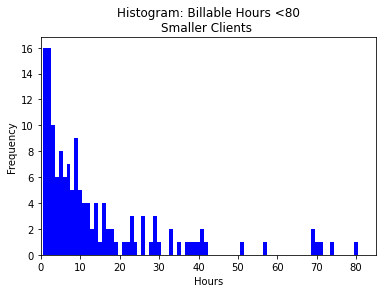

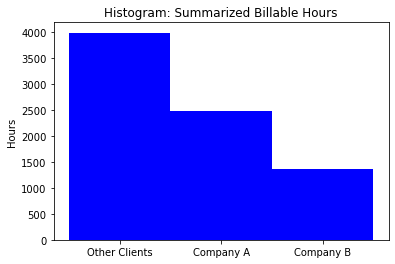

In [6]:
# //*** Productivity Data Frame: These Jobs make the money
billable_df = combined_df[combined_df['jobcode_2'].str.len() > 2]

#//*** Histogram of all billable hours. NOT EVENly distributed
#//*** Two Clients represent 50% of all hours. The remaining hours are split amongst many clients.
billable_hist = get_hist_variable_by_hours(billable_df,'jobcode_1')

#//*** Get hours of other clients (all hours minus the big client hours.)
other_total_hours = billable_df['hours'].sum() - 2484 - 1369

plt.bar(billable_hist.index, billable_hist,1,color="b")
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title("Histogram: All Billable Hours (per Client)")
plt.show()

plt.bar(billable_hist.index, billable_hist,1,color="b")
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.xlim(0,85)
plt.title("Histogram: Billable Hours <80\nSmaller Clients ")
plt.show()

plt.bar(['Other Clients',"Company A", "Company B"], [other_total_hours,2484,1369],1,color="b")
plt.ylabel('Hours')
plt.title("Histogram: Summarized Billable Hours")
plt.show()



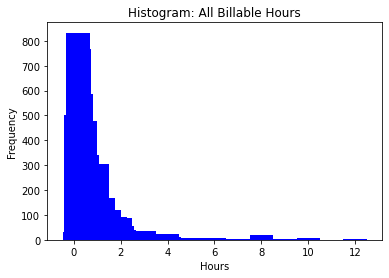

In [7]:
# //*** Productivity Data Frame: These Jobs make the money
billable_df = combined_df[combined_df['jobcode_2'].str.len() > 2]

billable_hist = billable_df['hours'].value_counts().sort_index()

plt.bar(billable_hist.index, billable_hist,1,color="b")
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title("Histogram: All Billable Hours")
plt.show()

0.02      18
0.03      34
0.05      64
0.07      69
0.08     767
        ... 
10.00      2
10.13      1
10.17      1
10.67      1
11.25      1
Name: hours, Length: 275, dtype: int64


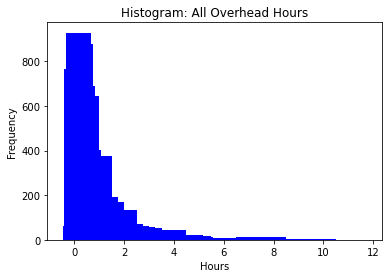

In [8]:
# //*** Overhead Work: It's Work that's gotta get done
overhead_df = combined_df[ combined_df['jobcode_1'].str.contains("Gabel",na=False) ]

overhead_hist = overhead_df['hours'].value_counts().sort_index()
print(overhead_hist)
plt.bar(overhead_hist.index, overhead_hist,1,color="b")
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title("Histogram: All Overhead Hours")
plt.show()

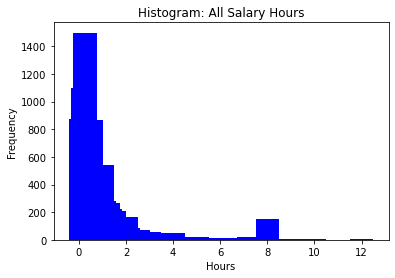

In [9]:
salary_df = combined_df[ combined_df['salary'] == 1]

salary_hours_hist = salary_df['hours'].value_counts().sort_index()

plt.bar(salary_hours_hist.index, salary_hours_hist,1,color="b")
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title("Histogram: All Salary Hours")
plt.show()

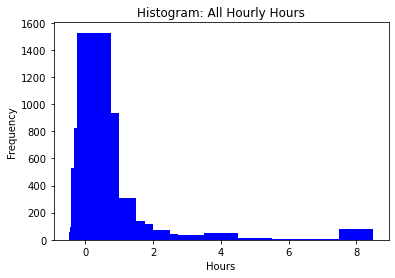

In [10]:
hourly_df = combined_df[ combined_df['salary'] == 0]

hourly_hours_hist = hourly_df['hours'].value_counts().sort_index()

plt.bar(hourly_hours_hist.index, hourly_hours_hist,1,color="b")
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.title("Histogram: All Hourly Hours")
plt.show()

Include the other descriptive characteristics about the variables: Mean, Mode, Spread, and Tails(Chapter 2)

In [11]:
print(combined_df['hours'].mean())
print(combined_df['hours'].median())
print(combined_df['hours'].mode())
print(np.std(combined_df['hours']))

0.9626596576592314
0.5
0    0.25
dtype: float64
1.3170262736816314


Using pg. 29 of your text as an example, compare two scenarios in your data using a PMF.  Reminder, this isn’t comparing two variables against each other –it is the same variable, but a different scenario.  Almost like a filter. The example in the book is first babies compared to all other babies, it is still the same variable, but breaking the data out based on criteria we are exploring(Chapter 3)

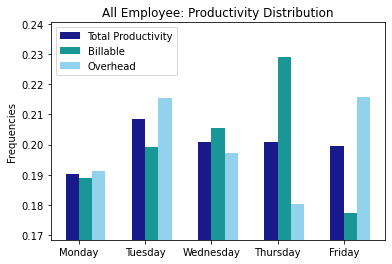

In [12]:
def build_pmf(input_series):
    output_series = input_series.copy()
    total_values = input_series.sum()
    for value,freq in output_series.items():
        #print(f"{value} {freq} {total_values} {freq/total_values}")
        output_series.loc[value] = freq/total_values
    return output_series

# //*** Productivity Data Frame: These Jobs make the money
billable_df = combined_df[combined_df['jobcode_2'].str.len() > 2]



# //*** Overhead Work: It's Work that's gotta get done
overhead_df = combined_df[ combined_df['jobcode_1'].str.contains("Gabel",na=False) ]

#print(productive_df['jobcode_1'].unique())
#print(overhead_df['jobcode_1'].unique())

total_employee_hours_distribution = []
billable_employee_hours_distribution = []
overhead_employee_hours_distribution = []
salary_billable_hours_distribution = []
salary_overhead_hours_distribution = []
hourly_billable_hours_distribution = []
hourly_overhead_hours_distribution = []

for x in g['days_of_week']:
    
    # //*** Get income hours for all Employees by day
    loop_billable = billable_df[billable_df['day'].str.contains(x) ]['hours'].sum()
    loop_billable_salary_df = billable_df[billable_df['day'].str.contains(x) ]
    
    # //*** Salary Billable Hours
    loop_salary_billable =loop_billable_salary_df[loop_billable_salary_df['salary'] == 1]['hours'].sum()

    # //*** Hourly Billable Hours
    loop_hourly_billable = loop_billable_salary_df[loop_billable_salary_df['salary'] == 0]['hours'].sum()
    
    
    
    
    
    # //*** Get Overhead hours for all Employees by day
    loop_overhead = overhead_df[overhead_df['day'].str.contains(x) ]['hours'].sum()
    loop_overhead_df = overhead_df[overhead_df['day'].str.contains(x) ]

    # //*** Salary Billable Hours by day of week
    loop_salary_overhead =loop_overhead_df[loop_overhead_df['salary'] == 1]['hours'].sum()
    
    # //*** Hourly Billable Hours
    loop_hourly_overhead =loop_overhead_df[loop_overhead_df['salary'] == 0]['hours'].sum()
    
    
    #print(f"{loop_salary_billable} - {loop_hourly_billable} : {loop_salary_overhead} - {loop_hourly_overhead}")
    
    # //*** Add to the lists
    total_employee_hours_distribution.append(loop_billable + loop_overhead)
    billable_employee_hours_distribution.append(loop_billable)
    overhead_employee_hours_distribution.append(loop_overhead)
    salary_billable_hours_distribution.append(loop_salary_billable) 
    salary_overhead_hours_distribution.append(loop_salary_overhead)
    hourly_billable_hours_distribution.append(loop_hourly_billable)
    hourly_overhead_hours_distribution.append(loop_hourly_overhead)


total_employee_hours_distribution = pd.Series( index=g['days_of_week'], data= total_employee_hours_distribution)
total_employee_hours_distribution_pmf = build_pmf(total_employee_hours_distribution)

billable_employee_hours_distribution = pd.Series(index=g['days_of_week'], data= billable_employee_hours_distribution)
billable_employee_hours_distribution_pmf = build_pmf(billable_employee_hours_distribution)

overhead_employee_hours_distribution = pd.Series(index=g['days_of_week'], data= overhead_employee_hours_distribution)
overhead_employee_hours_distribution_pmf = build_pmf(overhead_employee_hours_distribution)

salary_billable_hours_distribution = pd.Series(index=g['days_of_week'], data= salary_billable_hours_distribution)
salary_billable_hours_distribution = build_pmf(salary_billable_hours_distribution)

salary_overhead_hours_distribution = pd.Series(index=g['days_of_week'], data= salary_overhead_hours_distribution)
salary_overhead_hours_distribution = build_pmf(salary_overhead_hours_distribution)

hourly_billable_hours_distribution = pd.Series(index=g['days_of_week'], data= hourly_billable_hours_distribution)
hourly_billable_hours_distribution = build_pmf(hourly_billable_hours_distribution)

hourly_overhead_hours_distribution = pd.Series(index=g['days_of_week'], data= hourly_overhead_hours_distribution)
hourly_overhead_hours_distribution = build_pmf(hourly_overhead_hours_distribution)

#print(total_employee_hours_distribution_pmf)
#print(billable_employee_hours_distribution_pmf)
#print(overhead_employee_hours_distribution_pmf)    
#print(salary_billable_hours_distribution)    
#print(salary_overhead_hours_distribution)    
#print(hourly_billable_hours_distribution)    
#print(hourly_overhead_hours_distribution)    

#plt.style.use('ggplot')
n = 5
var1 = total_employee_hours_distribution_pmf
var2 = billable_employee_hours_distribution_pmf
var3 = overhead_employee_hours_distribution_pmf
fig, ax = plt.subplots()
index = np.arange(n)
bar_width = 0.2
opacity = 0.9
ax.bar(index, var1, bar_width, alpha=opacity, color='navy',label='Total Productivity')
                
ax.bar(index+bar_width, var2, bar_width, alpha=opacity, color='darkcyan', label='Billable')
ax.bar(index+(bar_width*2), var3, bar_width, alpha=opacity, color='skyblue', label='Overhead')
plt.ylim(billable_employee_hours_distribution_pmf.min() * .95,billable_employee_hours_distribution_pmf.max() * 1.05)
#ax.set_xlabel('Seasons')
ax.set_ylabel('Frequencies')
plt.title(f"All Employee: Productivity Distribution")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(g['days_of_week'])
ax.legend()
plt.show()
    

Create 1 CDF with one of your variables, using page 41-44 as your guide, what does this tell you about your variable and how does it address the question you are trying to answer(Chapter 4).

['Holiday' 'Lunch Break' 'Rest Break' 'PTO' 'Vacation']
1071.58
5045.8
6086.7


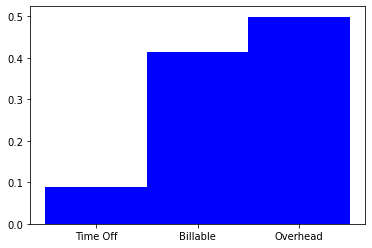

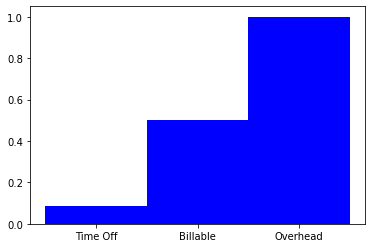

In [13]:
# //*** Build a Cumulative Distribution Function from a Probability Mass Function
# //*** Returns a Series
def build_cdf(input_series):
    # //*** If input is not panda or pd series, try to convert it
    if not isinstance(input_series,pd.core.series.Series):
        input_series = pd.Series(input_series)
        
    # //*** If input is np.Array
    output_series = input_series.copy()
    cumulative_value = 0
    for value,freq in output_series.items():
        #print(f"{value} {freq} {cumulative_value} {freq + cumulative_value}")
        cumulative_value = freq + cumulative_value
        output_series.loc[value] = cumulative_value
    return output_series

combined_employee_breaks = combined_df[ combined_df['activity'].isna() ]
combined_employee_breaks = combined_employee_breaks[ combined_employee_breaks['billable'].isna()]
combined_employee_breaks = combined_employee_breaks[ combined_employee_breaks['jobcode_1'] != "K2D Consulting Engineers"]
print(combined_employee_breaks['jobcode_1'].unique())

combined_employee_breaks_salary_1 = combined_employee_breaks[combined_employee_breaks['salary'] == 1 ]
combined_employee_breaks_salary_0 = combined_employee_breaks[combined_employee_breaks['salary'] == 0 ]

groups = combined_employee_breaks_salary_1.groupby('jobcode_1')

#//Excludingg Rest Break and Lunch Break, Since these times are non-billable and tracking if this time is arbitrary.
salary_timeoff_hours = 0

#//*** get Total hours for holiday PTO and Vacation
for group in groups:
    if group[0] in ['Holiday','PTO','Vacation']:
        salary_timeoff_hours += round(group[1]['hours'].sum(),2)

print(salary_timeoff_hours)

billable_salary_1_total = round(billable_df [billable_df['salary'] == 1 ]['hours'].sum(),2)
print(billable_salary_1_total)

overhead_salary_1_total = round(overhead_df [overhead_df['salary'] == 1 ]['hours'].sum(),2)

print(overhead_salary_1_total)
#//*** Build a salary CDF of time spent between TimeOff(Vacation, Timeoff )
salary_time_pmf = build_pmf(pd.Series(index=['Time Off','Billable','Overhead'], data=[salary_timeoff_hours,billable_salary_1_total,overhead_salary_1_total]))
salary_time_cdf = build_cdf(salary_time_pmf)

plt.bar(salary_time_pmf.index,salary_time_pmf,1,color="b")
plt.show()

plt.bar(salary_time_cdf.index,salary_time_cdf,1,color="b")
plt.show()


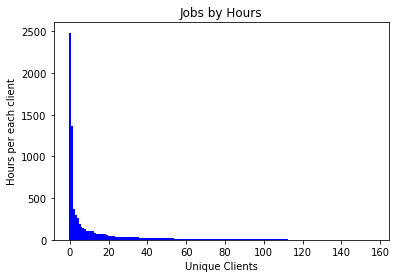

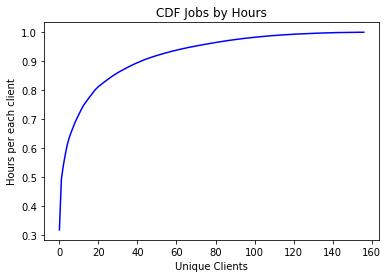

In [14]:
#pareto_cdf_series = scipy.stats.pareto.cdf(heights,scale=1, b=1.7)

billable_value_count = billable_df['jobcode_1'].value_counts().sort_values(ascending=False)

#print(billable_value_count)
# //********************************************************************
# //*** Build weighted values
# //********************************************************************
#print(f"{billable_value_count}")
#print(f"{jobcode1_value_count.index}")

# //*** Build a list of summed hours for each jobcode category
# //*** Loop through each billable jobcode to get the total hours for that job 
billable_hours_distribution = {}
for x in range(0,len(billable_value_count.index)):
    loop_key = billable_value_count.index[x]
    
    # //*** get total hours for each job
    billable_hours_distribution[loop_key] = combined_df[combined_df['jobcode_1'] == loop_key ]['hours'].sum()

# //*************************
# //*** Sort Billable Hours
# //*************************
# //*** https://www.geeksforgeeks.org/python-sort-python-dictionaries-by-key-or-value/
# //*** Builds a sorted dictionary
billable_hours_distribution = sorted(billable_hours_distribution.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
jobcode1_keys = []
jobcode1_values = []
# //*** Pull the sorted dictionary apart
for x in billable_hours_distribution:
    jobcode1_keys.append(x[0])
    jobcode1_values.append(x[1])

# //*** Reassemble as an ordered pandas series
billable_hours_distribution = pd.Series(index=jobcode1_keys, data=jobcode1_values)  

# //*** Build 
qlist = []
for x in range(0,len(billable_hours_distribution)):
    qlist.append(x)
# //*** Histogram with matplotlib
plt.bar(qlist, billable_hours_distribution, 1, color='b')
#plt.tight_layout()

#plt.xticks(jobcode1_value_count_top_20.index.values, jobcode1_value_count_top_20.index, rotation='vertical')
plt.title(f"Jobs by Hours")
plt.xlabel('Unique Clients')
plt.ylabel('Hours per each client')
plt.show()

#//*** CDF of Hours Distribution
billable_hours_distribution_cdf = build_cdf(build_pmf(billable_hours_distribution) )
plt.plot(qlist, billable_hours_distribution_cdf, 1, color='b')
#plt.tight_layout()

#plt.xticks(jobcode1_value_count_top_20.index.values, jobcode1_value_count_top_20.index, rotation='vertical')
plt.title(f"CDF Jobs by Hours")
plt.xlabel('Unique Clients')
plt.ylabel('Hours per each client')
plt.show()


Plot 1 analytical distribution and provide your analysis on how it applies to the dataset you have chosen (Chapter 5

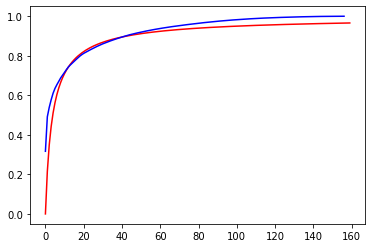

In [16]:
import scipy.stats
#https://numpy.org/doc/stable/reference/random/generated/numpy.random.pareto.html
a, m = 3, 10.  # shape and mode
a, m = 1, 5
#s = pd.Series( (np.random.pareto(a, 1000) ) * m ).value_counts().sort_index()
s = pd.Series( (np.random.default_rng(160).pareto(a, 1000) ) * m ).value_counts().sort_index()
s = s *10
s = build_cdf(build_pmf(s))


# //*** Generate a Pareto Culumlative distribution function as an np.array using a scale value of 1.7 (curve shape)
s = pd.Series(scipy.stats.pareto.cdf(np.linspace(6,160,160),scale=6, b=1))
s = pd.Series(scipy.stats.pareto.cdf(np.linspace(3,160,160),scale=3, b=.8))
s = pd.Series(scipy.stats.pareto.cdf(np.linspace(3,160,160),scale=3, b=.85))
s = pd.Series(scipy.stats.pareto.cdf(np.linspace(3,160,160),scale=3, b=.85))
#//*** Scale and Shape, Larger the scale, the more dispersed or flatter the curve, Shape affect the rate as it approaches to 100

#print(pareto_array)
plt.plot(s.index,s,1,color="red")
plt.plot(qlist, billable_hours_distribution_cdf, 1, color='b')
plt.show()
#print(billable_hours_distribution)

Create two scatter plots comparing two variables and provide your analysis on correlation and causation. Remember, covariance, Pearson’s correlation, and Non-Linear Relationships should also be considered during your analysis(Chapter 7).

In [35]:
#//Correlate Productivity between Salary Employees and Timeoff
#//*** Compary to Hourly Employees and TimeOff

#//*** Do a Time Series Plot Salary Productive Hours vs Timeoff

for date,day_df in combined_df.groupby('local_date'):
    
    #//*** Get Productive Hours for the day
    
    #print(day_df[day_df['salary']==1])
    print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
    
    
    
    #//*** Get All Salary productive Hours
    
    #//*** Get Mean Salary Productive Hours
    


<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi

Empty DataFrame
Columns: [local_date, hours, jobcode_1, jobcode_2, activity, billable, class, service item, emp_name, salary, activities, day_int, day]
Index: []
      local_date  hours                    jobcode_1  \
2     2019-01-02   1.08  ALTUS Architecture + Design   
4     2019-01-02   1.25        BDE Architecture Inc.   
9570  2019-01-02   1.00   Pacific Gas & Electric Co.   
14669 2019-01-02   0.33               DM Development   
14670 2019-01-02   1.08   Pacific Gas & Electric Co.   
14672 2019-01-02   0.42        BDE Architecture Inc.   
14674 2019-01-02   2.25               DM Development   

                                      jobcode_2               activity  \
2      19009 - Munson Residence and Guest House  Energy Model/Takeoffs   
4      17214 Walnut Creek Transit Village Phase  Energy Model/Takeoffs   
9570       18001 Codes &Standards Buildings Edu                    NaN   
14669        17076 - Octavia Blvd. Parcel T, SF               Revision   
14670      18001 Co

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                   jobcode_1  \
135   2019-01-18   0.33     Carollo Engineers, Inc.   
137   2019-01-18   0.42       BDE Architecture Inc.   
139   2019-01-18   0.25       BDE Architecture Inc.   
142   2019-01-18   1.25       BDE Architecture Inc.   
9658  2019-01-18   0.67               Brendan Kelly   
9661  2019-01-18   0.25  Pacific Gas & Electric Co.   
9667  2019-01-18   0.50  Pacific Gas & Electric Co.   
14774 2019-01-18   0.25     Robert Fukuda Architect   
17666 2019-01-18   0.67           Kuhl Architecture   
17669 2019-01-18   0.33           Kuhl Architecture   
17670 2019-01-18   0.42           Kuhl Architecture   
17671 2019-01-18   0.17           Kuhl Architecture   
17673 2019-01-18   0.17           Kuhl Architecture   
20600 2019-01-18   0.25  Pacific Gas & Electric Co.   
20602 2019-01-18   1.42                     NORESCO   

                                      jobcode_2  \
135                 19012 Modesto - River Trunk   
137       18348 

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                   jobcode_1  \
9769  2019-02-09   1.50  Pacific Gas & Electric Co.   
17822 2019-02-09   0.17           Kaplan Architects   
17823 2019-02-09   1.58           Kaplan Architects   
17826 2019-02-09   1.25           Kaplan Architects   
20769 2019-02-09   0.33                      Fisher   
20774 2019-02-09   7.75                      Fisher   

                                             jobcode_2               activity  \
9769   19001 Codes & Standards Buildings Edu (deleted)                    NaN   
17822                19029 - Heringer Dahnke Residence   Project Coordination   
17823                19029 - Heringer Dahnke Residence  Energy Model/Takeoffs   
17826                19029 - Heringer Dahnke Residence  Energy Model/Takeoffs   
20769                                   19025 440 Turk  Energy Model/Takeoffs   
20774                                   19025 440 Turk  Energy Model/Takeoffs   

      billable           class               

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                    jobcode_1  \
456   2019-02-27   0.83      Carollo Engineers, Inc.   
457   2019-02-27   0.33   Pacific Gas & Electric Co.   
459   2019-02-27   0.25   Pacific Gas & Electric Co.   
461   2019-02-27   1.25   Pacific Gas & Electric Co.   
463   2019-02-27   1.83   Pacific Gas & Electric Co.   
465   2019-02-27   0.17      Carollo Engineers, Inc.   
466   2019-02-27   1.33   Pacific Gas & Electric Co.   
9850  2019-02-27   0.58   Douglas Pancake Architects   
9851  2019-02-27   1.25   Pacific Gas & Electric Co.   
9854  2019-02-27   0.83   Pacific Gas & Electric Co.   
9855  2019-02-27   1.25        BDE Architecture Inc.   
14947 2019-02-27   2.08        BDE Architecture Inc.   
17991 2019-02-27   0.17               Daniel Hoy AIA   
17994 2019-02-27   0.75  Chris Spaulding,  Architect   
17995 2019-02-27   0.25  Chris Spaulding,  Architect   
17996 2019-02-27   0.33  Chris Spaulding,  Architect   
17998 2019-02-27   0.42            Jarvis Archi

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi

     local_date  hours                   jobcode_1  \
9924 2019-03-16   2.75  Pacific Gas & Electric Co.   
9925 2019-03-16   0.33  Pacific Gas & Electric Co.   
9926 2019-03-16   3.33  Pacific Gas & Electric Co.   
9928 2019-03-16   0.50  Pacific Gas & Electric Co.   
9929 2019-03-16   2.75  Douglas Pancake Architects   

                                            jobcode_2 activity billable  \
9924  19001 Codes & Standards Buildings Edu (deleted)      NaN      Yes   
9925  19001 Codes & Standards Buildings Edu (deleted)      NaN      Yes   
9926  19001 Codes & Standards Buildings Edu (deleted)      NaN      Yes   
9928  19001 Codes & Standards Buildings Edu (deleted)      NaN      Yes   
9929                      19066 Cadence Senior Living      NaN       No   

               class                          service item emp_name  salary  \
9924  Utilities:PG&E  Task 2 - Standards Essential Courses    EMP_6       1   
9925  Utilities:PG&E               Task 1 - Decoding Talks    EMP_

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                              jobcode_1  \
2955  2019-04-06   0.65             Pacific Gas & Electric Co.   
10025 2019-04-06   1.00             Pacific Gas & Electric Co.   
10026 2019-04-06   0.58  Pacific Gas & Electric - Kelly Task 4   
10027 2019-04-06   4.25             Pacific Gas & Electric Co.   
18306 2019-04-06   1.58             Pacific Gas & Electric Co.   

                                             jobcode_2  \
2955             19001 Codes & Standards Buildings Edu   
10025  19001 Codes & Standards Buildings Edu (deleted)   
10026                  19006 - Task 4 - Kelly Contract   
10027  19001 Codes & Standards Buildings Edu (deleted)   
18306            19001 Codes & Standards Buildings Edu   

                                                activity billable  \
2955            T#1803: Internal Management (add notes):      Yes   
10025                                                NaN      Yes   
10026                                         

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                              jobcode_1  \
760   2019-04-22   0.67                  BDE Architecture Inc.   
761   2019-04-22   1.33              Trachentenberg Architects   
763   2019-04-22   0.25              Trachentenberg Architects   
765   2019-04-22   1.50              Trachentenberg Architects   
767   2019-04-22   0.67              Trachentenberg Architects   
768   2019-04-22   3.08                  BDE Architecture Inc.   
2999  2019-04-22   0.67             Pacific Gas & Electric Co.   
3001  2019-04-22   1.00  Pacific Gas & Electric - Kelly Task 4   
10094 2019-04-22   0.75             Pacific Gas & Electric Co.   
10095 2019-04-22   0.17             Pacific Gas & Electric Co.   
10096 2019-04-22   1.08  Pacific Gas & Electric - Kelly Task 4   
10097 2019-04-22   1.25             Pacific Gas & Electric Co.   
10099 2019-04-22   1.33  Pacific Gas & Electric - Kelly Task 4   
10100 2019-04-22   1.08             Pacific Gas & Electric Co.   
10101 201

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                         jobcode_1  \
876   2019-05-08   0.25             BDE Architecture Inc.   
878   2019-05-08   0.33  Industrial Energy Services, Inc.   
880   2019-05-08   0.42  Industrial Energy Services, Inc.   
882   2019-05-08   1.00            Axis Development Group   
884   2019-05-08   0.67            Axis Development Group   
885   2019-05-08   0.67                     Block BF, LLC   
887   2019-05-08   0.83                     Block BF, LLC   
3047  2019-05-08   0.47        Pacific Gas & Electric Co.   
10150 2019-05-08   8.00        Pacific Gas & Electric Co.   
15375 2019-05-08   0.58                          Greystar   
15377 2019-05-08   1.33              RYS Architects, Inc.   
15378 2019-05-08   0.50                    DM Development   
15380 2019-05-08   1.25                    DM Development   
21508 2019-05-08   0.92        Pacific Gas & Electric Co.   
21511 2019-05-08   0.42        Pacific Gas & Electric Co.   
21513 2019-05-08   0.42

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                   jobcode_1  \
10191 2019-05-27   1.58  Pacific Gas & Electric Co.   
10193 2019-05-27   0.50  Pacific Gas & Electric Co.   
10194 2019-05-27   1.58  Pacific Gas & Electric Co.   
10195 2019-05-27   0.58  Pacific Gas & Electric Co.   

                                             jobcode_2 activity billable  \
10191  19001 Codes & Standards Buildings Edu (deleted)      NaN      Yes   
10193  19001 Codes & Standards Buildings Edu (deleted)      NaN      Yes   
10194  19001 Codes & Standards Buildings Edu (deleted)      NaN      Yes   
10195  19001 Codes & Standards Buildings Edu (deleted)      NaN      Yes   

                class                          service item emp_name  salary  \
10191  Utilities:PG&E       Task 3 - Compliance Improvement    EMP_6       1   
10193  Utilities:PG&E  Task 2 - Standards Essential Courses    EMP_6       1   
10194  Utilities:PG&E  Task 2 - Standards Essential Courses    EMP_6       1   
10195  Utilities:PG&E 

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi

      local_date  hours                   jobcode_1  \
1115  2019-06-12   1.42      Loeb Lighting Services   
1117  2019-06-12   0.33       BDE Architecture Inc.   
10240 2019-06-12   0.17  Pacific Gas & Electric Co.   
10241 2019-06-12   0.83  Pacific Gas & Electric Co.   
15548 2019-06-12   1.42                      Fisher   
15550 2019-06-12   0.17                         ASD   
15551 2019-06-12   0.67                      Fisher   
15552 2019-06-12   1.25          Loisos + Ubbelohde   
15555 2019-06-12   0.83                      Fisher   
15558 2019-06-12   1.92                      Fisher   
15559 2019-06-12   1.25                      Fisher   
15560 2019-06-12   3.25                      Fisher   
18874 2019-06-12   0.25              450 Architects   
18878 2019-06-12   0.25    Susan L Wootan Architect   
18880 2019-06-12   0.67   Wm. F. Holland, Architect   
18882 2019-06-12   0.08              450 Architects   
18884 2019-06-12   0.17    Susan L Wootan Architect   
18885 2019

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi

      local_date  hours                    jobcode_1  \
1300  2019-07-02   0.42        BDE Architecture Inc.   
1302  2019-07-02   0.50                    HOMEOWNER   
1304  2019-07-02   0.33        BDE Architecture Inc.   
1306  2019-07-02   0.42                    HOMEOWNER   
1308  2019-07-02   0.33              Rogers Electric   
1309  2019-07-02   0.42        BDE Architecture Inc.   
1310  2019-07-02   0.58    Trachentenberg Architects   
1314  2019-07-02   0.08        BDE Architecture Inc.   
3190  2019-07-02   0.50   Pacific Gas & Electric Co.   
3193  2019-07-02   0.45   Pacific Gas & Electric Co.   
10312 2019-07-02   1.42                      NORESCO   
10314 2019-07-02   0.75                      NORESCO   
10315 2019-07-02   0.17   Pacific Gas & Electric Co.   
10317 2019-07-02   0.58   Pacific Gas & Electric Co.   
10319 2019-07-02   0.33   Pacific Gas & Electric Co.   
10320 2019-07-02   1.67  SAN DIEGO GAS & ELECTRIC CO   
15667 2019-07-02   1.00           Loisos + Ubbel

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                    jobcode_1  \
1466  2019-07-24   0.92   Pacific Gas & Electric Co.   
1468  2019-07-24   1.00                    SiteLogiq   
1469  2019-07-24   0.92        BDE Architecture Inc.   
1472  2019-07-24   0.67        BDE Architecture Inc.   
1474  2019-07-24   0.83        BDE Architecture Inc.   
1477  2019-07-24   0.92                          WSP   
10418 2019-07-24   0.25   Pacific Gas & Electric Co.   
10419 2019-07-24   1.67   Pacific Gas & Electric Co.   
10421 2019-07-24   1.42                      NORESCO   
10422 2019-07-24   0.42                      NORESCO   
10423 2019-07-24   0.17                      NORESCO   
10424 2019-07-24   0.17   Pacific Gas & Electric Co.   
10426 2019-07-24   0.42   Pacific Gas & Electric Co.   
10427 2019-07-24   0.33                      NORESCO   
10428 2019-07-24   0.50   Pacific Gas & Electric Co.   
10429 2019-07-24   1.75                      NORESCO   
10430 2019-07-24   1.08   Pacific Gas & Electri

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi

     local_date  hours jobcode_1                                 jobcode_2  \
1585 2019-08-10    3.0       WSP  19127 - Palo Alto Public Safety Building   

                   activity billable           class  \
1585  Energy Model/Takeoffs       No  Nonresidential   

                     service item emp_name  salary activities  day_int  \
1585  Energy Code Compliance Work    EMP_1       1        NaN        5   

           day  
1585  Saturday  
Empty DataFrame
Columns: [local_date, hours, jobcode_1, jobcode_2, activity, billable, class, service item, emp_name, salary, activities, day_int, day]
Index: []
      local_date  hours                   jobcode_1  \
1589  2019-08-12   0.17      Loeb Lighting Services   
1591  2019-08-12   0.33      Loeb Lighting Services   
1593  2019-08-12   1.92                         WSP   
1595  2019-08-12   0.92                         WSP   
1596  2019-08-12   0.42      Loeb Lighting Services   
1597  2019-08-12   0.08                         WSP   


<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi

      local_date  hours                         jobcode_1  \
1711  2019-08-28   0.42             BDE Architecture Inc.   
1719  2019-08-28   0.58  Industrial Energy Services, Inc.   
1721  2019-08-28   0.42                         SiteLogiq   
10600 2019-08-28   3.08                           NORESCO   
10602 2019-08-28   0.92                           NORESCO   
10604 2019-08-28   0.67       SAN DIEGO GAS & ELECTRIC CO   
15965 2019-08-28   1.75             BDE Architecture Inc.   
15966 2019-08-28   0.67        Pacific Gas & Electric Co.   
15970 2019-08-28   0.50             BDE Architecture Inc.   
19431 2019-08-28   0.83                 Jarvis Architects   
19433 2019-08-28   0.25                         HOMEOWNER   
19434 2019-08-28   0.75                         HOMEOWNER   

                                           jobcode_2  \
1711                                   17048-MKC W12   
1719              18199 Walmart Lighting Alterations   
1721                           19191 W

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                        jobcode_1  \
1848  2019-09-18   0.50                              WSP   
1849  2019-09-18   0.33            BDE Architecture Inc.   
1851  2019-09-18   1.08                    Block BF, LLC   
1857  2019-09-18   0.58            BDE Architecture Inc.   
1859  2019-09-18   1.00            BDE Architecture Inc.   
10655 2019-09-18   8.00      SAN DIEGO GAS & ELECTRIC CO   
16093 2019-09-18   0.25    MESH Design Build Studio Inc.   
16094 2019-09-18   1.58       Pacific Gas & Electric Co.   
16095 2019-09-18   0.92    MESH Design Build Studio Inc.   
19558 2019-09-18   0.33  Bay Area Designer Builders, Inc   
19561 2019-09-18   1.00        Jim Jennings Architecture   
19566 2019-09-18   0.75        Kasia Ekstrand, Architect   
19567 2019-09-18   0.67        Kasia Ekstrand, Architect   
19568 2019-09-18   0.33        Kasia Ekstrand, Architect   
22529 2019-09-18   0.33                          NORESCO   
22532 2019-09-18   2.08                

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                             jobcode_1  \
2004  2019-10-04   1.92                 BDE Architecture Inc.   
2008  2019-10-04   0.08                 BDE Architecture Inc.   
10707 2019-10-04   0.92            Pacific Gas & Electric Co.   
10708 2019-10-04   2.17            Pacific Gas & Electric Co.   
10711 2019-10-04   2.08            Pacific Gas & Electric Co.   
16179 2019-10-04   0.50            Pacific Gas & Electric Co.   
16180 2019-10-04   1.00            Pacific Gas & Electric Co.   
16182 2019-10-04   0.50                              Greystar   
16186 2019-10-04   0.67  CA/AG Logan Park Property Owner, LLC   
16190 2019-10-04   0.67                              Greystar   
19726 2019-10-04   1.50                     Jarvis Architects   
19730 2019-10-04   0.92       Bay Area Designer Builders, Inc   
19734 2019-10-04   0.25                       FB Design Build   
19737 2019-10-04   0.25       Bay Area Designer Builders, Inc   
19738 2019-10-04   0.17 

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi

      local_date  hours                   jobcode_1  \
19890 2019-10-20   1.75  Pacific Gas & Electric Co.   

                                   jobcode_2                      activity  \
19890  19001 Codes & Standards Buildings Edu  T31824: CEA Exam Development   

      billable           class                     service item emp_name  \
19890      Yes  Utilities:PG&E  Task 3 - Compliance Improvement   EMP_11   

       salary activities  day_int     day  
19890       1        NaN        6  Sunday  
      local_date  hours                     jobcode_1  \
10778 2019-10-21   2.08                       NORESCO   
10780 2019-10-21   3.75  ALLIANCE RESIDENTIAL COMPANY   
10782 2019-10-21   1.17  ALLIANCE RESIDENTIAL COMPANY   
16284 2019-10-21   0.17                           WSP   
16285 2019-10-21   0.83                      Greystar   
16286 2019-10-21   0.58                      Greystar   
16288 2019-10-21   3.25                      Greystar   
16289 2019-10-21   0.58            

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                   jobcode_1  \
2236  2019-11-08   0.17       BDE Architecture Inc.   
10846 2019-11-08   1.00                     NORESCO   
10847 2019-11-08   3.08  Pacific Gas & Electric Co.   
10848 2019-11-08   3.33                     NORESCO   
10849 2019-11-08   1.33  Pacific Gas & Electric Co.   
16376 2019-11-08   1.08                     NORESCO   
16378 2019-11-08   0.58                     NORESCO   
16381 2019-11-08   0.42       BDE Architecture Inc.   
16386 2019-11-08   1.17  Pacific Gas & Electric Co.   
16389 2019-11-08   0.58  Pacific Gas & Electric Co.   
20093 2019-11-08   0.50                   HOMEOWNER   
20094 2019-11-08   0.33   William Pettus, Architect   
20095 2019-11-08   0.17                   HOMEOWNER   
20100 2019-11-08   0.33                   HOMEOWNER   
20101 2019-11-08   0.42                   HOMEOWNER   
20102 2019-11-08   0.25                   HOMEOWNER   
20104 2019-11-08   0.42   William Pettus, Architect   
20105 201

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi


      local_date  hours                   jobcode_1  \
2348  2019-11-26   0.17                         WSP   
2349  2019-11-26   0.42            Ecomodern Design   
2355  2019-11-26   1.58                         WSP   
2357  2019-11-26   1.00                         WSP   
2359  2019-11-26   0.08                         WSP   
3597  2019-11-26   2.00  Pacific Gas & Electric Co.   
10919 2019-11-26   0.75  Pacific Gas & Electric Co.   
10921 2019-11-26   5.58  Pacific Gas & Electric Co.   
20253 2019-11-26   0.83   Jim Jennings Architecture   
20259 2019-11-26   0.17         Italo Capestri, AIA   
20261 2019-11-26   0.50           Jarvis Architects   
20262 2019-11-26   0.33           Jarvis Architects   
20264 2019-11-26   2.08  Pacific Gas & Electric Co.   
23068 2019-11-26   0.17  Pacific Gas & Electric Co.   
23069 2019-11-26   1.25  Pacific Gas & Electric Co.   
23071 2019-11-26   0.25  Pacific Gas & Electric Co.   
23073 2019-11-26   0.92  Pacific Gas & Electric Co.   
23076 201

<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi

      local_date  hours                        jobcode_1  \
2484  2019-12-11   0.42            BDE Architecture Inc.   
2486  2019-12-11   0.67            BDE Architecture Inc.   
2488  2019-12-11   0.08            BDE Architecture Inc.   
2490  2019-12-11   0.58            BDE Architecture Inc.   
2494  2019-12-11   1.42            BDE Architecture Inc.   
20404 2019-12-11   0.25  Frank A. Bergamaschi, Architect   
20406 2019-12-11   1.00    MESH Design Build Studio Inc.   
20410 2019-12-11   2.67                Jensen Architects   
23198 2019-12-11   1.00       Pacific Gas & Electric Co.   

                                   jobcode_2               activity billable  \
2484             17346-MKC Bay Meadows Res 4   Project Coordination      Yes   
2486             17346-MKC Bay Meadows Res 4   Project Coordination      Yes   
2488                 17404 YBI San Francisco             CA: Review      Yes   
2490                 17404 YBI San Francisco             CA: Review      Yes   

      local_date  hours                   jobcode_1  \
11008 2019-12-31    3.0  Pacific Gas & Electric Co.   

                                             jobcode_2 activity billable  \
11008  19001 Codes & Standards Buildings Edu (deleted)      NaN      Yes   

           class             service item emp_name  salary  \
11008  Utilities  Task 1 - Decoding Talks    EMP_6       1   

                        activities  day_int      day  
11008  T12001: Decoding Energy Pro        1  Tuesday  


<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(day_df[day_df['jobcode_2'].isna() == False][day_df['salary']==1])
<ipython-input-35-928d0ed572a0>:11: UserWarning: Boolean Series key wi

Conduct a test on your hypothesis using one of the methods covered in Chapter 9.

In [ ]:
#//**** Compare Results of Correlation to Random p tests? d